# Setup

### Imports

In [1]:
import time
import os
from dataclasses import dataclass
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt
import scipy.spatial.distance
import transformers
from datasets import load_dataset

import lib.sst as sst
import lib.utils as utils

### Configuration

In [2]:
transformers.utils.logging.set_verbosity_error()
utils.fix_random_seeds()

cpu_device = 'cpu'
gpu_device = 'cuda' if torch.cuda.is_available() else 'cpu'

params = {
    'text.usetex': True,
    'text.latex.preamble': r"\usepackage{lmodern}",
    'font.size': 11,
    'font.family': 'lmodern',
    'figure.figsize': (6, 6),
    'figure.dpi': 100,
    'savefig.dpi': 1000,}

plt.rcParams.update(params)


### Load Datasets

In [3]:
dyna_r1 = load_dataset("dynabench/dynasent", "dynabench.dynasent.r1.all")
dyna_r1_dev = dyna_r1['validation'].to_pandas()
dyna_r1_test = dyna_r1['test'].to_pandas()
dyna_r2 = load_dataset("dynabench/dynasent", "dynabench.dynasent.r2.all")
dyna_r2_train = dyna_r2['train'].to_pandas()
dyna_r2_dev = dyna_r2['validation'].to_pandas()
dyna_r2_test = dyna_r2['test'].to_pandas()
print(f'dyna_r1_dev.shape: {dyna_r1_dev.shape}')
print(f'dyna_r2_dev.shape: {dyna_r2_dev.shape}')

DEV_DATAFRAMES = [dyna_r1_dev, dyna_r2_dev]
# TEST_DATAFRAMES = [dyna_r1_test, dyna_r2_test]

print(f'Dev dataset length:  {sum([len(df) for df in DEV_DATAFRAMES])}')
# print(f'Test dataset length: {sum([len(df) for df in TEST_DATAFRAMES])}')

Reusing dataset dynabench_dyna_sent (C:\Users\Gabe\.cache\huggingface\datasets\dynabench___dynabench_dyna_sent\dynabench.dynasent.r1.all\1.1.0\ab89971d9ae1aacc59ed44d6855bf0e89167417257e2c2666f38e532148f2967)
100%|██████████| 3/3 [00:00<00:00, 374.65it/s]
Reusing dataset dynabench_dyna_sent (C:\Users\Gabe\.cache\huggingface\datasets\dynabench___dynabench_dyna_sent\dynabench.dynasent.r2.all\1.1.0\ab89971d9ae1aacc59ed44d6855bf0e89167417257e2c2666f38e532148f2967)
100%|██████████| 3/3 [00:00<00:00, 499.54it/s]

dyna_r1_dev.shape: (3600, 12)
dyna_r2_dev.shape: (720, 12)
Dev dataset length:  4320


### Load Saved Experiments

In [4]:
# TODO warn if not found
experiment_file_names = [
    'experiment_RoBERTa-Base (Baseline).pt',
    'experiment_RoBERTa-Base (AAN).pt',
    'experiment_DynaSent-M1 (Baseline).pt',
    'experiment_DynaSent-M1 (AAN).pt',
]

colors = ['orangered', 'orangered', 'dodgerblue', 'dodgerblue']
linestyles = [(0, (5, 1)), 'solid'] * 2
hatches = ['//', None] * 2
    
experiments = []
for file_name, color, linestyle, hatch in zip(experiment_file_names, colors, linestyles, hatches):
    experiment = torch.load(os.path.join('models', file_name))
    # Force CPU to not run out of GPU memory with all models loaded
    experiment['model'].device = cpu_device
    experiment['model'].model.to(cpu_device)
    experiment['model'].model.eval()
    experiment['graph_color'] = color
    experiment['graph_linestyle'] = linestyle
    experiment['graph_hatch'] = hatch
    experiments.append(experiment)
    print(f'Loaded experiment for model {experiment["model"]}')

Loaded experiment for model RoBERTa-Base (Baseline)
Loaded experiment for model RoBERTa-Base (AAN)
Loaded experiment for model DynaSent-M1 (Baseline)
Loaded experiment for model DynaSent-M1 (AAN)


# 1. Quantitative Performance Evaluation

### Training Metrics

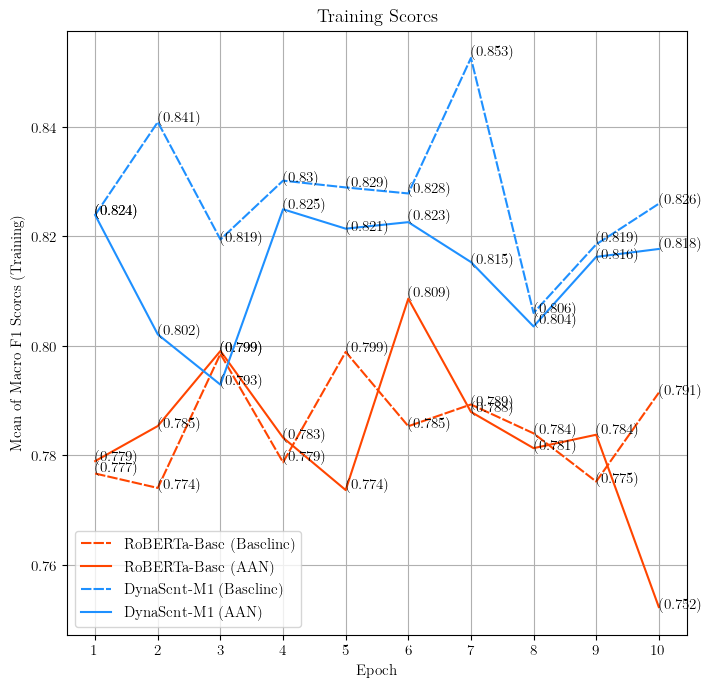

In [5]:
# Plot validation scores computed during training on held-out portions of the train set
for experiment in experiments:
    scores = experiment['model'].validation_scores
    epochs = list(range(1, len(scores) + 1))
    plt.plot(epochs, scores, label=f'{experiment["model"]}',
        color=experiment['graph_color'], linestyle=experiment['graph_linestyle'])
    # Data labels
    rounded_scores = [round(score, 3) for score in scores]
    for xy in zip(epochs, rounded_scores):
        plt.annotate('(%s)' % xy[1], xy=xy, textcoords='data')

plt.ylabel('Mean of Macro F1 Scores (Training)')
plt.xlabel('Epoch')
plt.title('Training Scores')
plt.grid()
plt.xticks(epochs)
plt.legend()

plt.savefig(os.path.join('plots', 'Training Scores.png'))

plt.show()


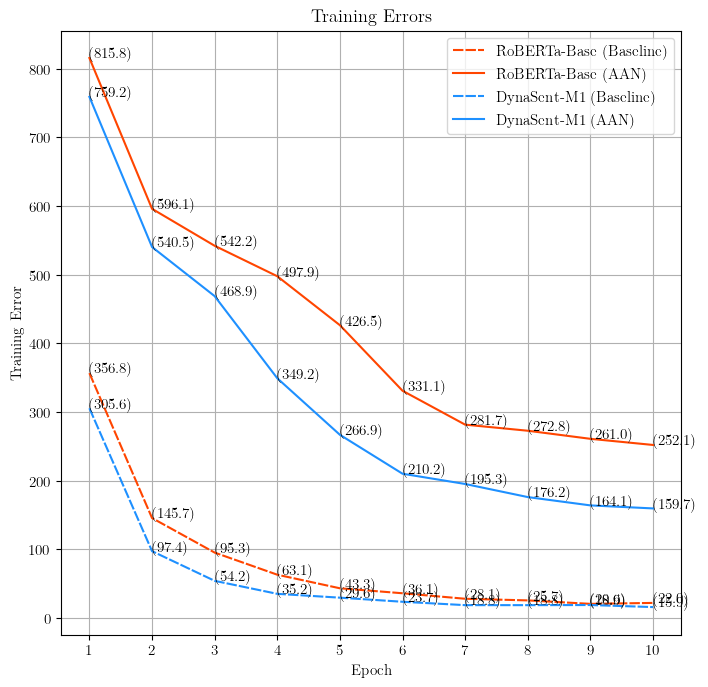

In [6]:
# Plot training losses
for experiment in experiments:
    errors = experiment['model'].training_errors
    epochs = list(range(1, len(errors) + 1))
    plt.plot(epochs, errors, label=f'{experiment["model"]}',
        color=experiment['graph_color'], linestyle=experiment['graph_linestyle'])
    # Data labels
    rounded_errors = [round(error, 1) for error in errors]
    for xy in zip(epochs, rounded_errors):
        plt.annotate('(%s)' % xy[1], xy=xy, textcoords='data')

plt.ylabel('Training Error')
plt.xlabel('Epoch')
plt.title('Training Errors')
plt.grid()
plt.xticks(epochs)
plt.legend()

plt.savefig(os.path.join('plots', 'Training Errors.png'))

plt.show()


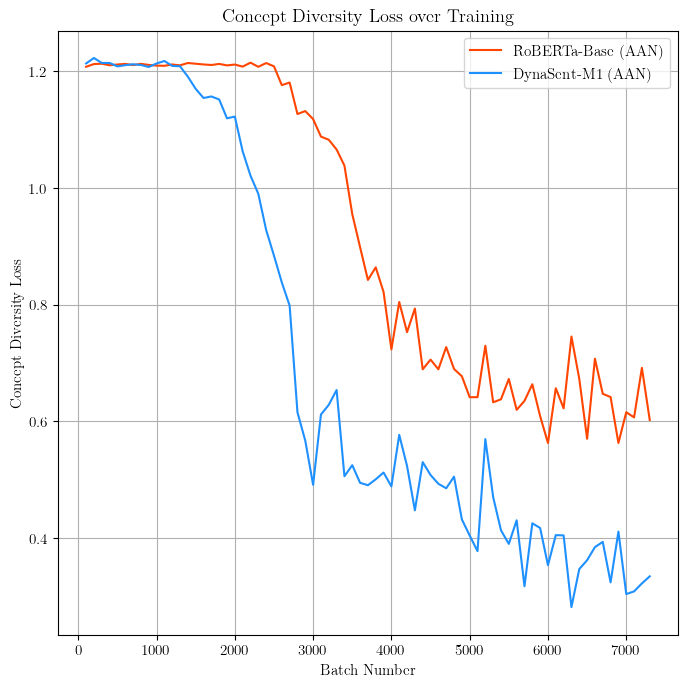

In [7]:
# Plot just the diversity loss component for the AAN models over training
for experiment in [experiments[1], experiments[3]]:
    diversity_penalties = experiment['model'].loss.diversity_penalties
    batches = list(range(1, len(diversity_penalties) + 1))
    batches = [batch * 100 for batch in batches]
    plt.plot(batches, diversity_penalties, label=f'{experiment["model"]}',
        color=experiment['graph_color'], linestyle=experiment['graph_linestyle'])

plt.ylabel('Concept Diversity Loss')
plt.xlabel('Batch Number')
plt.title('Concept Diversity Loss over Training')
plt.grid()
# plt.xticks(batches)
plt.legend()

plt.savefig(os.path.join('plots', 'Training Errors Diversity.png'))

plt.show()


### Dev Set Evaluation

In [13]:
def evaluate_dataset(assess_df, title, score_func=utils.safe_macro_f1):
    # Build the dataset for assessment
    assess = sst.build_dataset(
        assess_df,
        experiments[0]['phi'],
        vectorize=False)

    # Run the model and assess the predictions
    scores = []
    all_preds = []
    for experiment in experiments:
        model = experiment['model']
        print(f'Evaluating {model}' , end =': ')
        
        # Move to GPU for faster processing
        model.device = gpu_device
        model.model.to(gpu_device)
        preds = model.predict(assess['X'])
        model.model.to(cpu_device)
        model.device = cpu_device
        
        score = score_func(assess['y'], preds)
        scores.append(score)
        all_preds.append(preds)
        print(score)

    for experiment, score in zip(experiments, scores):
        model_name = str(experiment['model'])
        model_name = '\n('.join(model_name.split(' ('))  # Split to new lines
        plt.bar(model_name, score, color=experiment['graph_color'], hatch=experiment['graph_hatch'])
    plt.ylabel('Mean of Macro F1 Scores (Evaluation)')
    plt.xlabel('Model')
    plt.title(title)

    plt.savefig(os.path.join('plots', f'{title}.png'))

    return scores, all_preds, assess['y']
    

Evaluating RoBERTa-Base (Baseline): 0.6820114090464182
Evaluating RoBERTa-Base (AAN): 0.6729728043244415
Evaluating DynaSent-M1 (Baseline): 0.7308669129330049
Evaluating DynaSent-M1 (AAN): 0.7046678324424369


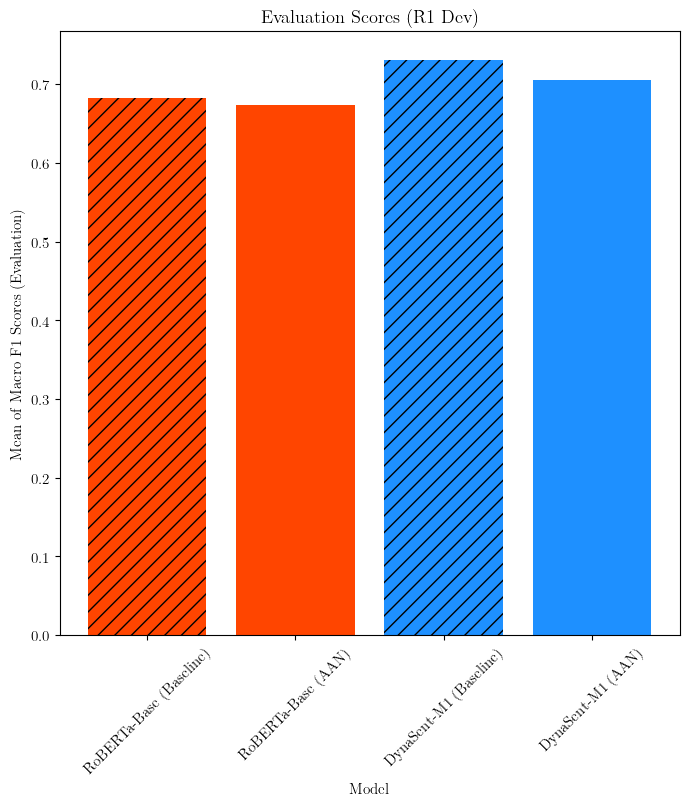

In [9]:
# Dynasent Round 1 Dev
dyna_r1_dev_scores, dyna_r1_dev_preds, dyna_r1_dev_gold = evaluate_dataset(dyna_r1_dev, 'Evaluation Scores (R1 Dev)')

# This cell takes about 1 minutes on an RTX 2070

Evaluating RoBERTa-Base (Baseline): 0.6608728685785229
Evaluating RoBERTa-Base (AAN): 0.6303124197387414
Evaluating DynaSent-M1 (Baseline): 0.6574574552795042
Evaluating DynaSent-M1 (AAN): 0.6889906415344275


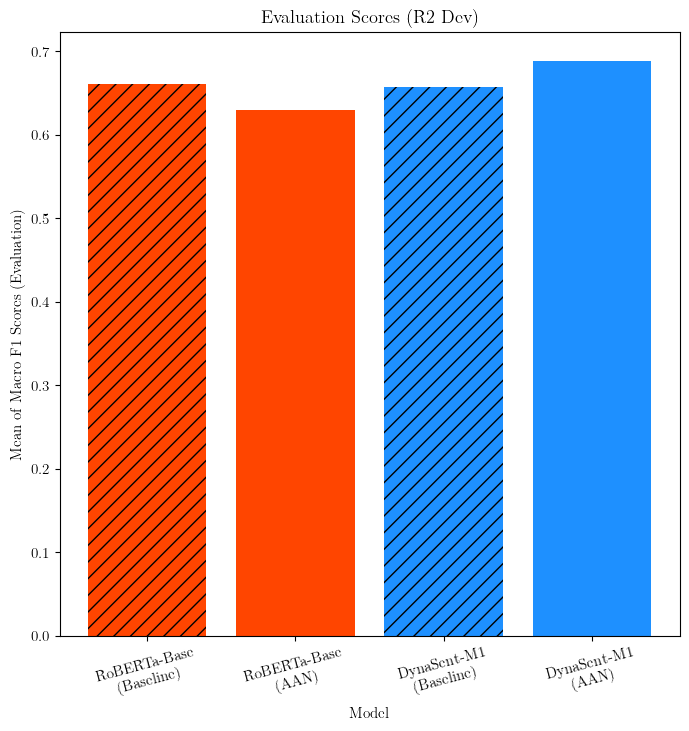

In [14]:
# Dynasent Round 2 Dev
dyna_r2_dev_scores, dyna_r2_dev_preds, dyna_r2_dev_gold = evaluate_dataset(dyna_r2_dev, 'Evaluation Scores (R2 Dev)')

### Test Set Evaluation
Evaluate on test sets once at the end of model development.

Evaluating RoBERTa-Base (Baseline): 0.6951926195968343
Evaluating RoBERTa-Base (AAN): 0.6919810506423744
Evaluating DynaSent-M1 (Baseline): 0.7398151248380224
Evaluating DynaSent-M1 (AAN): 0.7097710269500883


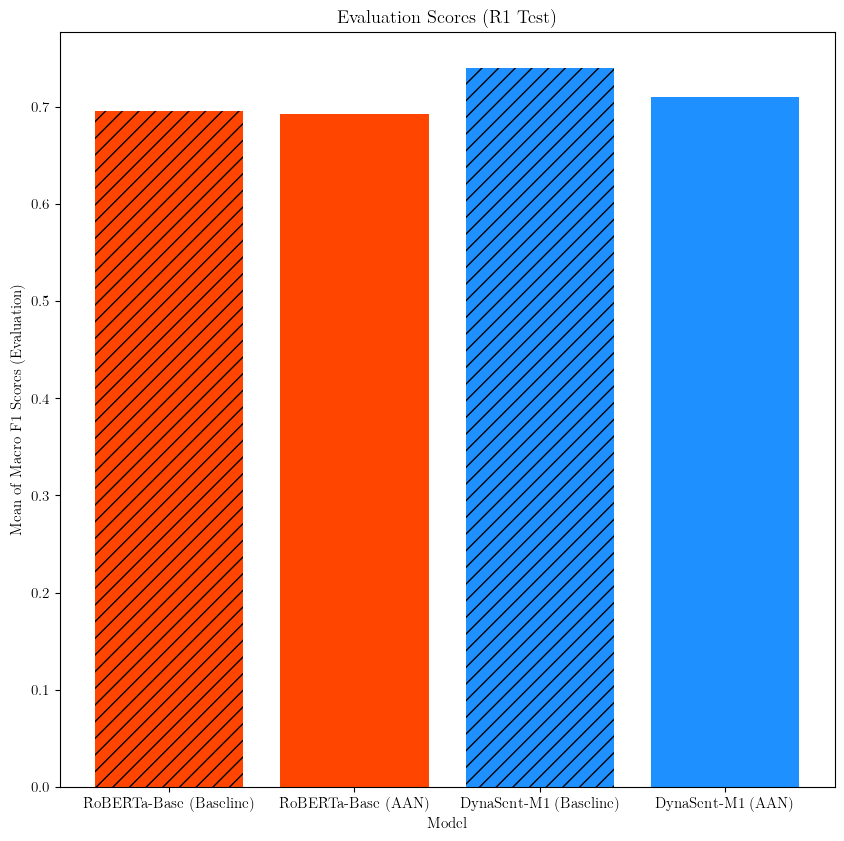

In [11]:
# Dynasent Round 1 Test
dyna_r1_test_scores, dyna_r1_test_preds, dyna_r1_test_gold = evaluate_dataset(dyna_r1_test, 'Evaluation Scores (R1 Test)')

# This cell takes about 1.2 minutes on an RTX 2070

Evaluating RoBERTa-Base (Baseline): 0.683222746498691
Evaluating RoBERTa-Base (AAN): 0.645197090626054
Evaluating DynaSent-M1 (Baseline): 0.6621150800558667
Evaluating DynaSent-M1 (AAN): 0.7219678503338586


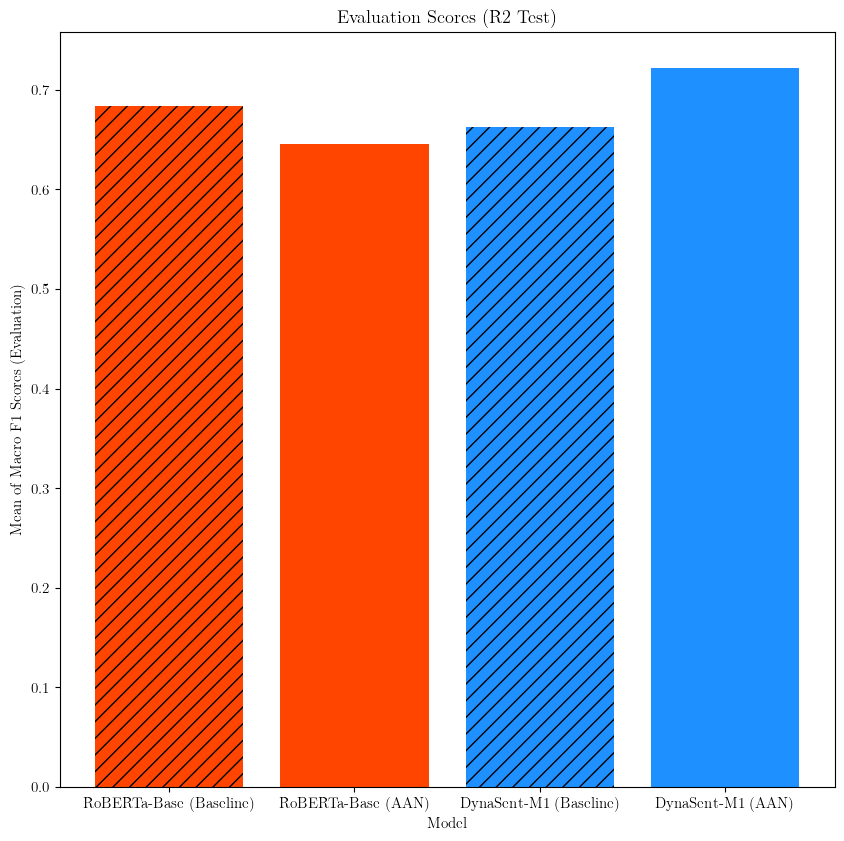

In [12]:
# Dynasent Round 2 Test
dyna_r2_test_scores, dyna_r2_test_preds, dyna_r2_test_gold = evaluate_dataset(dyna_r2_test, 'Evaluation Scores (R2 Test)')

### McNemar's Test of Statistical Significance

We can use [McNemar's Test](https://en.wikipedia.org/wiki/McNemar%27s_test) to evaluate whether the predictions of two different models on the same data set are statistically significant. If they aren't statistically significant (e.g. p > 0.01), then we can conclude that the models don't perform differently on that dataset.

In [13]:
# Use McNemar's Test to evaluate whether classifier outputs are significantly different
def calculate_significance(test_name, gold_labels, model_1_preds, model_2_preds):
    p_threshold = 0.01
    _, significance = utils.mcnemar(gold_labels, model_1_preds, model_2_preds)
    is_significant_text = 'NOT significant' if significance > p_threshold else 'SIGNIFICANT'
    print(f'p={significance:.3g} ({is_significant_text}) for test {test_name}')
    return significance

significance_tests = [
    ('Dyna R1 Dev', None, None, None), # line break
    ('Dyna R1 Dev: RoBERTa Baseline vs RoBERTa AAN', dyna_r1_dev_gold, dyna_r1_dev_preds[0], dyna_r1_dev_preds[1]),
    ('Dyna R1 Dev: DynaSent-M1 Baseline vs DynaSent-M1 AAN', dyna_r1_dev_gold, dyna_r1_dev_preds[2], dyna_r1_dev_preds[3]),
    ('Dyna R1 Dev: RoBERTa Baseline vs DynaSent-M1 Baseline', dyna_r1_dev_gold, dyna_r1_dev_preds[0], dyna_r1_dev_preds[2]),
    ('Dyna R1 Dev: RoBERTa AAN vs DynaSent-M1 AAN', dyna_r1_dev_gold, dyna_r1_dev_preds[1], dyna_r1_dev_preds[3]),
    ('\nDyna R2 Dev', None, None, None), # line break
    ('Dyna R2 Dev: RoBERTa Baseline vs RoBERTa AAN', dyna_r2_dev_gold, dyna_r2_dev_preds[0], dyna_r2_dev_preds[1]),
    ('Dyna R2 Dev: DynaSent-M1 Baseline vs DynaSent-M1 AAN', dyna_r2_dev_gold, dyna_r2_dev_preds[2], dyna_r2_dev_preds[3]),
    ('Dyna R2 Dev: RoBERTa Baseline vs DynaSent-M1 Baseline', dyna_r2_dev_gold, dyna_r2_dev_preds[0], dyna_r2_dev_preds[2]),
    ('Dyna R2 Dev: RoBERTa AAN vs DynaSent-M1 AAN', dyna_r2_dev_gold, dyna_r2_dev_preds[1], dyna_r2_dev_preds[3]),
    ('\nDyna R1 Test', None, None, None), # line break
    ('Dyna R1 Test: RoBERTa Baseline vs RoBERTa AAN', dyna_r1_test_gold, dyna_r1_test_preds[0], dyna_r1_test_preds[1]),
    ('Dyna R1 Test: DynaSent-M1 Baseline vs DynaSent-M1 AAN', dyna_r1_test_gold, dyna_r1_test_preds[2], dyna_r1_test_preds[3]),
    ('Dyna R1 Test: RoBERTa Baseline vs DynaSent-M1 Baseline', dyna_r1_test_gold, dyna_r1_test_preds[0], dyna_r1_test_preds[2]),
    ('Dyna R1 Test: RoBERTa AAN vs DynaSent-M1 AAN', dyna_r1_test_gold, dyna_r1_test_preds[1], dyna_r1_test_preds[3]),
    ('\nDyna R2 Test', None, None, None), # line break
    ('Dyna R2 Test: RoBERTa Baseline vs RoBERTa AAN', dyna_r2_test_gold, dyna_r2_test_preds[0], dyna_r2_test_preds[1]),
    ('Dyna R2 Test: DynaSent-M1 Baseline vs DynaSent-M1 AAN', dyna_r2_test_gold, dyna_r2_test_preds[2], dyna_r2_test_preds[3]),
    ('Dyna R2 Test: RoBERTa Baseline vs DynaSent-M1 Baseline', dyna_r2_test_gold, dyna_r2_test_preds[0], dyna_r2_test_preds[2]),
    ('Dyna R2 Test: RoBERTa AAN vs DynaSent-M1 AAN', dyna_r2_test_gold, dyna_r2_test_preds[1], dyna_r2_test_preds[3]),
]

for test_name, gold_labels, model_1_preds, model_2_preds in significance_tests:
    if gold_labels == None:
        print(test_name)
    else:
        calculate_significance(test_name, gold_labels, model_1_preds, model_2_preds)

Dyna R1 Dev
p=0.0881 (NOT significant) for test Dyna R1 Dev: RoBERTa Baseline vs RoBERTa AAN
p=0.000427 (SIGNIFICANT) for test Dyna R1 Dev: DynaSent-M1 Baseline vs DynaSent-M1 AAN
p=3.72e-10 (SIGNIFICANT) for test Dyna R1 Dev: RoBERTa Baseline vs DynaSent-M1 Baseline
p=2.28e-05 (SIGNIFICANT) for test Dyna R1 Dev: RoBERTa AAN vs DynaSent-M1 AAN

Dyna R2 Dev
p=0.192 (NOT significant) for test Dyna R2 Dev: RoBERTa Baseline vs RoBERTa AAN
p=0.0738 (NOT significant) for test Dyna R2 Dev: DynaSent-M1 Baseline vs DynaSent-M1 AAN
p=0.863 (NOT significant) for test Dyna R2 Dev: RoBERTa Baseline vs DynaSent-M1 Baseline
p=0.00932 (SIGNIFICANT) for test Dyna R2 Dev: RoBERTa AAN vs DynaSent-M1 AAN

Dyna R1 Test
p=0.384 (NOT significant) for test Dyna R1 Test: RoBERTa Baseline vs RoBERTa AAN
p=3.9e-05 (SIGNIFICANT) for test Dyna R1 Test: DynaSent-M1 Baseline vs DynaSent-M1 AAN
p=1.63e-08 (SIGNIFICANT) for test Dyna R1 Test: RoBERTa Baseline vs DynaSent-M1 Baseline
p=0.0109 (NOT significant) for test

# Concept-Based Explanations

Our AAN-based models are able to produce concept-based explanations of their classification decisions.

We choose to run all of our explanations on the DynaSent Model 1 AAN model, but these could also be evaluated on the RoBERTA-Base AAN model or other AAN models.

### Precomputation

In [14]:
# Use the DynaSent Model 1 AAN
desired_model_name = 'DynaSent-M1 (AAN)' # 'RoBERTa-Base (AAN)'
concept_explanation_model = [experiment['model'] for experiment in experiments if str(experiment['model']) == desired_model_name][0]
concept_explanation_model.model.to(gpu_device)
concept_explanation_model.device = gpu_device

In [15]:
# Choose a dictionary of keywords to use as inputs

# Import a small (25k) English dictionary
# https://github.com/dolph/dictionary
with open('data/popular.txt') as word_file:
    concept_keyword_list = np.array(word_file.read().split())

# Debug choose only a random 1000
# concept_keyword_list = concept_keyword_list[np.random.choice(len(concept_keyword_list), size=1000, replace=False)]

# Alternative: Use RoBERTa's tokens (50k tokens)
# tokenizer = concept_explanation_model.roberta_tokenizer
# concept_keyword_list: list[str] = list(tokenizer.vocab.keys())

num_concept_keywords = len(concept_keyword_list)
print(f'Loaded {num_concept_keywords} keywords. Examples:')
print(concept_keyword_list[np.random.choice(num_concept_keywords, size=6, replace=False)])

Loaded 25322 keywords. Examples:
['cram' 'legislature' 'untoward' 'waves' 'hurray' 'decked']


In [16]:
# Precompute (or load) the abstraction-attention context representations (10x768) for each keyword.
# We will compare these representations to find keywords associated with concepts.
from lib.sentiment_models import NUM_CONCEPTS, HIDDEN_DIM, BATCH_SIZE

FORCE_COMPUTE_REPRESENTATIONS = True

keywords_representations_save_path = os.path.join('data', 'keywords_representations.npy')
must_precompute_representations = not os.path.exists(keywords_representations_save_path) or FORCE_COMPUTE_REPRESENTATIONS
if not must_precompute_representations:
    print(f'Loading representations for {num_concept_keywords} keywords...')
    keywords_representations = np.load(keywords_representations_save_path)
    print(f'Loaded representations for {len(keywords_representations)} keywords.')

    if len(keywords_representations) != num_concept_keywords:
        print(f'Whoops! Loaded {len(keywords_representations)} keyword representations, but was expecting {num_concept_keywords}. Regenerating them now.')
        must_precompute_representations = True

if must_precompute_representations:
    print(f'Precomputing representations for {num_concept_keywords} keywords...')

    keywords_representations = np.zeros((num_concept_keywords, NUM_CONCEPTS, HIDDEN_DIM))

    num_batches = (num_concept_keywords / BATCH_SIZE) + 1

    start_time = time.time()
    for batch_i in range(0, num_concept_keywords, BATCH_SIZE):
        # Forward the input through the model so it stores the attention contexts
        batch_inputs = concept_keyword_list[batch_i:batch_i+BATCH_SIZE].tolist()
        concept_explanation_model.predict(batch_inputs)

        fraction_complete = (batch_i + 1) / num_concept_keywords
        minutes_since_start = (time.time() - start_time) / 60
        minutes_expected = minutes_since_start / fraction_complete * (1 - fraction_complete)
        message = f'Keyword {batch_i + 1}/{num_concept_keywords} ' \
            f'({round(fraction_complete * 100, 2)}%). ' \
            f'{round(minutes_since_start, 2)} min elapsed, {round(minutes_expected, 2)} min remaining. '
        utils.progress_bar(message)

        # Capture the saved attention contexts
        ctx_abs = concept_explanation_model.pooling_module.ctx_abs.detach().cpu()
        keywords_representations[
            batch_i:min(batch_i + BATCH_SIZE, num_concept_keywords), :, :] = ctx_abs

    np.save(keywords_representations_save_path, keywords_representations)

Precomputing representations for 25322 keywords...


### Explanation Generation

In [39]:
@dataclass
class ConceptExplanation:
    """Represents an explanation of a single sentence and facilitates easy printing."""
    sentence: str # The input sentence
    prediction: str # The sentiment prediction
    scores: list[float] # The scores for each of the K concepts
    keywords: list[list[str]] # The keywords for each of the K concepts

    def get_explanation_string(self, sort_by_scores=True):
        table_string = f'{"Concept":^8}{"Score":^10}{"Keywords":<20}\n'
        table_string += '='*100 + '\n'

        # Sorting by scores
        indices = range(NUM_CONCEPTS)
        if sort_by_scores:
            indices = np.array(self.scores).argsort()[::-1]

        for id in indices:
            score = self.scores[id]
            keyword_list = self.keywords[id]
            table_string += f'{id:^8} {score:.5f}  {", ".join(keyword_list):<20}\n'

        return f'Prediction: {str.upper(self.prediction)}\nSentence: "{self.sentence}"\n{table_string}'

    def __repr__(self):
        return self.get_explanation_string()


def get_concept_explanation(sentence, num_keywords_per_concept=6, distance_metric=scipy.spatial.distance.cosine):
    """Gets the scores and keywords for the K=10 concepts for a given input sentence."""
    # Forward the input through the model
    prediction = concept_explanation_model.predict([sentence])[0]

    # Capture the saved attention weights
    ctx_abs = concept_explanation_model.pooling_module.ctx_abs.detach().cpu()
    attn_agg = concept_explanation_model.pooling_module.attn_agg.detach().cpu()

    # Get the scores from the aggregation-attention weights
    scores = attn_agg.squeeze().numpy().tolist()

    # Compute the cosine distance between this sentence's abs-attention context representations
    # and the precomputed keyword representations (each are of size NUM_CONCEPTS x HIDDEN_DIM).
    distances = np.zeros((num_concept_keywords, NUM_CONCEPTS))
    for keyword_i in range(num_concept_keywords):
        for concept_i in range(NUM_CONCEPTS):
            sentence_repr = ctx_abs[:, concept_i, :].squeeze().numpy()
            keyword_repr = keywords_representations[keyword_i, concept_i, :]
            distances[keyword_i, concept_i] = distance_metric(sentence_repr, keyword_repr)

    # Choose to top n most similar keywords to represent each concept (smallest cosine distances)
    keywords = [[]]*NUM_CONCEPTS
    for concept_i in range(NUM_CONCEPTS):
        indices = distances[:, concept_i].argsort()[:num_keywords_per_concept]
        keywords[concept_i] = concept_keyword_list[indices]

    # Wrap it all up in a cozy object
    return ConceptExplanation(sentence, prediction, scores, keywords)

### Example Explanations
Test the explanations with some hand-written and training set example sentences.

In [40]:
print(get_concept_explanation('If they said it would be excellent, then why did the food taste that way?'))

Prediction: NEGATIVE
Sentence: "If they said it would be excellent, then why did the food taste that way?"
Concept   Score   Keywords            
   5     0.22237  inconsiderate, talentless, untraceable, incapacitate, disappoints, unimaginative
   7     0.18077  incapacitate, incompetent, uncooperative, inconsiderate, shoplifters, disappoints
   6     0.16904  incompetence, incompetent, misdemeanors, murderess, shoplifters, scrutiny
   0     0.16794  talentless, disappoints, shoplifters, scrutiny, frustrates, flaws
   2     0.16191  crucifixion, inaccuracies, sourpuss, nausea, incompetence, infuriating
   4     0.09087  sordid, aargh, incessantly, incapacitate, bogus, disgrace
   9     0.00403  disgraced, cholinesterase, boredom, interfering, disheartening, irritated
   8     0.00294  horseshit, souvlaki, bobcat, disinherit, doofus, dummkopf
   3     0.00007  disgraced, crucifixion, inconsiderate, incompetence, disgustingly, motherfuckers
   1     0.00006  suckers, crucifixion, infuria

In [41]:
print(get_concept_explanation('Customer service is fast!'))

Prediction: POSITIVE
Sentence: "Customer service is fast!"
Concept   Score   Keywords            
   0     0.19972  lovesick, vibrating, brilliance, dynamic, flawless, grinning
   2     0.15075  loved, liked, excels, exceeded, nailed, appreciates
   6     0.12409  excellent, genius, awesome, profound, phenomena, immense
   8     0.12352  glamour, pamper, sophistication, glamor, enchantment, cutesy
   7     0.12342  whirlwind, gorgeous, vivid, stunningly, wicked, triumphs
   4     0.10067  exceed, blockbusters, awol, miraculous, enthusiasm, thanking
   5     0.09460  perfecting, addictive, best, perfectly, stylish, perfection
   9     0.06785  sublime, stunning, excellent, spectacular, trusting, superior
   1     0.01447  succeeds, magnificent, triumphs, succeeded, excels, hallelujah
   3     0.00090  seamless, triumphs, magnificent, gorgeous, breathtaking, excels



In [42]:
print(get_concept_explanation('My doctor is a woman.'))

Prediction: NEUTRAL
Sentence: "My doctor is a woman."
Concept   Score   Keywords            
   0     0.19566  floodgates, caboose, gazebo, flapjacks, worshippers, tattoos
   5     0.17893  chimpanzee, lidocaine, crocodile, hippopotamus, bachelorette, rhinoceros
   6     0.17637  coconut, wrestler, nocturnal, sixpence, fibre, biochemist
   7     0.17099  rattlesnake, puppeteer, newlyweds, wrestler, nocturnal, coconut
   2     0.14616  prednisone, journeyed, sleet, jezebel, rhinoceros, honeysuckle
   4     0.05593  insignia, disregard, smashes, unquote, relieved, disbelief
   9     0.03988  cholinesterase, aforementioned, remainder, nocturnal, extraterrestrials, unattached
   8     0.02159  bobcat, souvlaki, angioplasty, pantyhose, hippopotamus, hayloft
   1     0.01416  boogeyman, snowballed, unscheduled, inconspicuous, skewed, malfeasance
   3     0.00032  toxoplasmosis, caterwauling, sarcoidosis, sauerkraut, dummkopf, horseshit



In [43]:
print(get_concept_explanation('My doctor is a man.'))

Prediction: NEUTRAL
Sentence: "My doctor is a man."
Concept   Score   Keywords            
   9     0.19214  undisclosed, aforementioned, unattached, remainder, nearby, dissident
   0     0.18781  floodgates, caboose, gazebo, flapjacks, tattoos, worshippers
   7     0.15122  diabetics, biochemist, closest, mathematician, snowmobile, wrestler
   6     0.15000  biochemist, snowmobile, mathematician, anesthesiologist, stereotype, venetian
   2     0.14120  prednisone, journeyed, sleet, jezebel, rhinoceros, bridegroom
   5     0.07292  puppeteer, hayloft, psychotherapist, evolution, windsurfing, zebra
   4     0.06420  insignia, smashes, unquote, disregard, relieved, disbelief
   8     0.02716  bobcat, souvlaki, hippopotamus, braggart, angioplasty, maggot
   1     0.01307  boogeyman, snowballed, inconspicuous, skewed, malfeasance, unscheduled
   3     0.00029  caterwauling, toxoplasmosis, sarcoidosis, dummkopf, sauerkraut, horseshit



In [44]:
print(get_concept_explanation('The egg drop soup was as delicious as the long-forgotten, untouched fruitcake that my mother made for me decades ago!'))

Prediction: NEGATIVE
Sentence: "The egg drop soup was as delicious as the long-forgotten, untouched fruitcake that my mother made for me decades ago!"
Concept   Score   Keywords            
   0     0.24669  talentless, shoplifters, disappoints, uncontrollable, frustrates, scrutiny
   2     0.21372  crucifixion, inaccuracies, sourpuss, nausea, incompetence, opportune
   5     0.19457  unconscionable, inconsiderate, talentless, inconsolable, claustrophobic, untraceable
   7     0.16315  misogynistic, motherfuckers, disgrace, infuriates, nausea, exasperating
   6     0.10383  shoplifters, malfeasance, murderess, incompetence, inconveniencing, misdemeanors
   4     0.06724  sordid, aargh, unimpressed, incapacitate, revenge, disgrace
   8     0.00656  horseshit, souvlaki, sarcoidosis, bobcat, angioplasty, sauerkraut
   9     0.00404  cholinesterase, eucalyptus, extraterrestrials, disgraced, vertebrae, electrolyte
   3     0.00012  disgraced, incompetence, crucifixion, inconsiderate, disgus

In [45]:
print(get_concept_explanation('The food look really bad, it looked as it was over cooked, to my surprise I was highly mistaken.'))

Prediction: POSITIVE
Sentence: "The food look really bad, it looked as it was over cooked, to my surprise I was highly mistaken."
Concept   Score   Keywords            
   2     0.26460  succeeds, exceedingly, enjoyed, enjoys, mesmerizing, succeeded
   0     0.19576  intrigues, scintillating, brilliance, flawless, glamorous, vibrating
   5     0.17943  succeeds, scintillating, unconscionable, exhilarated, exhilaration, penetrating
   7     0.15514  incapacitated, uplink, disinherit, exceedingly, entertained, succeeded
   6     0.12895  incapacitate, incapacitated, incompetence, incompetent, incomprehensible, whatchamacallit
   4     0.06826  succeeds, hallelujah, succeeded, exhilaration, enthralled, succeed
   8     0.00584  souvlaki, horseshit, sauerkraut, dummkopf, whatchamacallit, sarcoidosis
   9     0.00184  cholinesterase, eucalyptus, disgraced, extraterrestrials, vertebrae, electrolyte
   3     0.00012  disgraced, incompetence, incapacitated, disgustingly, inconsiderate, disprop

In [46]:
print(get_concept_explanation('The staff has always been friendly and willing to help with any questions I\'ve had.'))

Prediction: POSITIVE
Sentence: "The staff has always been friendly and willing to help with any questions I've had."
Concept   Score   Keywords            
   2     0.27254  succeeds, exceedingly, enjoys, enjoyed, mesmerizing, enamored
   0     0.22177  brilliance, scintillating, intrigues, glamorous, vibrating, glamour
   5     0.17385  scintillating, succeeds, exhilaration, exhilarated, penetrating, gallivanting
   7     0.13236  exceedingly, succeeded, succeeds, wondrous, intrigue, sophisticated
   8     0.08909  whatchamacallit, hallelujah, exhilaration, extraordinaire, extravaganza, uplink
   6     0.05876  whatchamacallit, extraordinaire, mausoleum, enthusiastic, enthusiast, congeniality
   4     0.03352  hallelujah, succeeds, extravaganza, enthusiasm, enthralled, enthusiastic
   9     0.01684  shorthanded, disgraced, evangelical, comprehensive, enamored, unforgiving
   1     0.00112  suckers, succeeds, motherfuckers, tiresome, wastebasket, boredom
   3     0.00015  disgraced, di

# Explaining Errors

We can use our concept-based explanations to try to transparently discover errors and biases in the model.

### Error analysis

We use DataFrames to analyze our model's output and select examples based on certain criteria.

In [47]:
def find_errors(sentences, predictions, gold_labels):
    """Find mistaken predictions.
    Returns
    -------
    pd.DataFrame

    """
    df = pd.DataFrame({
        'raw_examples': sentences,
        'predicted': predictions,
        'gold': gold_labels})
    df['correct'] = df['predicted'] == df['gold']
    return df

In [48]:
# Find errors with the DynaSent-M1 AAN model on the DynaSent Round 2 test set.
aan_analysis = find_errors(dyna_r2_test.sentences, dyna_r2_test_preds[3], dyna_r2_test_gold)

In [49]:
# Examples where the model is correct and the gold label is 'positive' or 'negative'
true_positives = aan_analysis[
    (aan_analysis['correct'] == True)
    &
    (aan_analysis['gold'] == 'positive')
]
true_neutrals = aan_analysis[
    (aan_analysis['correct'] == True)
    &
    (aan_analysis['gold'] == 'neutral')
]
true_negatives = aan_analysis[
    (aan_analysis['correct'] == True)
    &
    (aan_analysis['gold'] == 'negative')
]

# Examples where the model is incorrectly 'positive'/'negative and the gold label is 'negative'/'positive'
# Note these are subsets of all false 'positives'/'negatives' since there is a 'neutral' class.
opposite_positives = aan_analysis[
    (aan_analysis['predicted'] == 'positive')
    &
    (aan_analysis['gold'] == 'negative')
]
opposite_negatives = aan_analysis[
    (aan_analysis['predicted'] == 'negative')
    &
    (aan_analysis['gold'] == 'positive')
]

# Print out the counts and some examples
print(f'{true_positives.shape[0]} True Positives')
for ex in true_positives['raw_examples'].sample(3, random_state=1):
    print(f'"{ex}"')

print(f'\n{true_neutrals.shape[0]} True Neutrals')
for ex in true_neutrals['raw_examples'].sample(3, random_state=1):
    print(f'"{ex}"')

print(f'\n{true_negatives.shape[0]} True Negatives')
for ex in true_negatives['raw_examples'].sample(3, random_state=1):
    print(f'"{ex}"')


print(f'\n{opposite_positives.shape[0]} Oppositive Positives')
for ex in opposite_positives['raw_examples'].sample(3, random_state=1):
    print(f'"{ex}"')

print(f'\n{opposite_negatives.shape[0]} Oppositive Negatives')
for ex in opposite_negatives['raw_examples'].sample(3, random_state=1):
    print(f'"{ex}"')

912 True Positives
Mike is very knowledgeable, he knows the company, his products, and services.
The volume I left enamoured with? It was amazing.
Tons of parking!
1239 True Positives
Mike is very knowledgeable, he knows the company, his products, and services.
The volume I left enamoured with? It was amazing.
Tons of parking!

897 True Negatives
We had a rough go at it tonight but I assure we will learn from it and be better for it.
Purposely, i call the man who standing at the cashier and he just staring at me without doing anything...
Attention: they charge to use WiFi!

165 Oppositive Positives
The only downside to assigned seating, is if you have a friend who wants to go with you last minute and they aren't  able to get a seat next to you bc it's been booked.
Needles to say I've been staying away from fast food for a reason and Burger King you pretty much proved my point.
When owned by the Hilton Corp, it was way better.

195 Oppositive Negatives
I had an incident with someone tam

### Correct Classifications

Where the model was correct.

In [50]:
print("Examples the model correctly predicted 'positive':\n")
for ex in true_positives['raw_examples'].sample(5, random_state=1):
    print(get_concept_explanation(ex))

Examples the model correctly predicted 'positive':
Prediction: POSITIVE
Sentence: "Mike is very knowledgeable, he knows the company, his products, and services."
Concept   Score   Keywords            
   0     0.25822  brilliance, intrigues, scintillating, vibrating, glamorous, flawless
   2     0.25812  succeeds, exceedingly, enjoys, excels, succeeded, enjoyed
   7     0.16264  exceedingly, succeeded, succeeds, wondrous, intrigue, intriguing
   4     0.11761  succeeds, hallelujah, enthusiasm, enthralled, extravaganza, impounded
   5     0.08011  unconscionable, succeeds, scintillating, exhilaration, exhilarated, gallivanting
   9     0.06530  egomaniacal, shorthanded, freshening, unbeatable, disgraced, eucalyptus
   6     0.05133  whatchamacallit, extraordinaire, mausoleum, enthusiastic, malfeasance, congeniality
   8     0.00481  souvlaki, horseshit, sauerkraut, whatchamacallit, sarcoidosis, dummkopf
   1     0.00166  suckers, motherfuckers, succeeds, tiresome, wastebasket, boredom
 

In [51]:
print("Examples the model correctly predicted 'neutral':\n")
for ex in true_neutrals['raw_examples'].sample(5, random_state=1):
    print(get_concept_explanation(ex))

Examples the model correctly predicted 'neutral':
Prediction: NEUTRAL
Sentence: "It actually looks almost like a doughnut."
Concept   Score   Keywords            
   5     0.20836  chimpanzee, catalog, basically, diagram, hydrochloride, arachnid
   0     0.20101  floodgates, worshippers, gazebo, caboose, flapjacks, cappuccino
   9     0.18669  narcolepsy, firstly, unplugged, disappearing, tagged, therefore
   2     0.17696  prednisone, journeyed, sleet, somerset, defeated, jezebel
   7     0.16595  cataloging, beheading, blindfolded, dislodged, disguised, remodelling
   6     0.03721  sauerkraut, gobbledygook, horseshit, muckraker, claustrophobia, souvlaki
   4     0.01939  revenge, iambic, doppelganger, disbelief, squealed, disregard
   1     0.00277  tiresome, suckers, wastebasket, foolhardy, warped, motherfuckers
   8     0.00148  souvlaki, toxoplasmosis, horseshit, sauerkraut, sarcoidosis, bobcat
   3     0.00018  sauerkraut, toxoplasmosis, disgraced, disproportionate, sarcoidosis,

In [52]:
print("Examples the model correctly predicted 'negative':\n")
for ex in true_negatives['raw_examples'].sample(5, random_state=1):
    print(get_concept_explanation(ex))

Examples the model correctly predicted 'negative':
Prediction: NEGATIVE
Sentence: "We had a rough go at it tonight but I assure we will learn from it and be better for it."
Concept   Score   Keywords            
   5     0.24104  inconsiderate, incomprehensible, incapacitated, incapacitate, unconscionable, uncontrollable
   0     0.20110  uncontrollable, lovesick, brilliance, shoplifters, flawless, scintillating
   2     0.19678  inaccuracies, crucifixion, sourpuss, unbearably, nausea, abrasive
   7     0.16674  motherfuckers, disgrace, misogynistic, sacrificing, imperfection, smugness
   6     0.10287  inconveniencing, shoplifters, malfeasance, incompetence, murderess, whatchamacallit
   4     0.08346  predecessors, revenge, aargh, arbitration, sordid, disgrace
   9     0.00392  cholinesterase, eucalyptus, extraterrestrials, disgraced, vertebrae, electrolyte
   8     0.00374  horseshit, souvlaki, sauerkraut, bobcat, sarcoidosis, shenanigans
   1     0.00022  suckers, crucifixion, infu

### Opposite Classification Errors

Where the model predicted the complete opposite of the gold label.

In [53]:
print("Examples the model predicted 'positive' but were truly 'negative':\n")
for ex in opposite_positives['raw_examples'].sample(5, random_state=1):
    print(get_concept_explanation(ex))

Examples the model predicted 'positive' but were truly 'negative':

Prediction: POSITIVE
Sentence: "The only downside to assigned seating, is if you have a friend who wants to go with you last minute and they aren't  able to get a seat next to you bc it's been booked."
Concept   Score   Keywords            
   0     0.27855  brilliance, lovesick, scintillating, flawless, glamorous, glamour
   2     0.25969  crucifixion, inaccuracies, succeeds, sourpuss, patronized, unwittingly
   7     0.17927  disgrace, motherfuckers, misogynistic, sacrificing, infuriates, exceedingly
   5     0.11663  preeclampsia, unconscionable, claustrophobia, claustrophobic, smorgasbord, hygienist
   6     0.10151  whatchamacallit, malfeasance, mausoleum, shoplifters, extraordinaire, sauerkraut
   4     0.05852  revenge, iambic, arbitration, predecessors, unforgiving, squealed
   9     0.00424  cholinesterase, eucalyptus, extraterrestrials, vertebrae, electrolyte, egomaniacal
   8     0.00135  souvlaki, dummkopf,

In [54]:
print("Examples the model predicted 'negative' but were truly 'positive':\n")
for ex in opposite_negatives['raw_examples'].sample(5, random_state=1):
    print(get_concept_explanation(ex))

Examples the model predicted 'negative' but were truly 'positive':

Prediction: NEGATIVE
Sentence: "I had an incident with someone tampering w/my a/c unit a few days ago & they came out within 20 min."
Concept   Score   Keywords            
   5     0.24914  claustrophobic, claustrophobia, unconscionable, talentless, inconsiderate, preeclampsia
   2     0.22521  crucifixion, inaccuracies, sourpuss, devastatingly, misdemeanors, nausea
   0     0.21933  shoplifters, loses, talentless, scrutiny, flaws, lacks
   7     0.18620  motherfuckers, sacrificing, misogynistic, disgrace, marshmallows, smugness
   4     0.06108  revenge, aargh, sordid, arbitration, predecessors, incessantly
   6     0.04734  shoplifters, malfeasance, murderess, muckraker, sauerkraut, horseshit
   9     0.00748  cholinesterase, eucalyptus, extraterrestrials, vertebrae, electrolyte, disgraced
   8     0.00401  souvlaki, horseshit, sarcoidosis, dummkopf, sauerkraut, toxoplasmosis
   3     0.00012  disgraced, crucifixion

### Bias Explanation

In [55]:
# TODO do some hand-written biased sentences to reveal biases in the model.